# Assignment Starter Code

# 🗳️ Individual Assignment – Electoral Analysis

## **Introduction**

This assignment investigates how electoral outcomes in Germany can be better understood when examined beyond simple *winner–takes–all* representations.  
The analysis is divided into two main parts, each addressing a key question.

---

### **Part 1 – Why does the winner map not accurately represent voters’ will?**

Conventional *winner maps*, which color each electoral district by the party receiving the most votes, often create a misleading impression of political polarization.  
Such maps ignore how close the results are and overlook that, in many districts, the winning party gained **less than 50%** of the total votes — meaning that most citizens supported other parties.  
To provide a more realistic picture, this section visualizes **vote shares**, **non-winner shares**, and **top-two majorities**, demonstrating how these measures better capture the true preferences of voters across Germany.

---

### **Part 2 – Is there a connection between structural data and party dominance?**

The second part examines whether socio-economic structures influence voting behavior.  
It tests well-known assumptions such as:  
- **High income → FDP**  
- **Low income → SPD**  
- **High unemployment → AfD**  
- **High education → Greens**

By merging district-level election results with demographic and economic indicators, the analysis applies descriptive statistics, correlation tests, and regression models to explore how factors like income, education, unemployment, and population density are associated with regional voting outcomes.

---

### **Objective**

Together, both parts aim to provide a data-driven, nuanced understanding of how the **distribution of votes** and the **underlying socio-economic conditions** jointly shape electoral patterns across Germany.


In [60]:
# 🧩 Setup Cell — Import All Required Libraries

# --- Core & Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize, TwoSlopeNorm, PowerNorm
from matplotlib.ticker import PercentFormatter

# --- Geospatial Analysis ---
import geopandas as gpd
import mapclassify as mc  # for quantile/choropleth bins
import shapely
import pyproj

# --- Statistics & Modeling ---
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Display Settings ---
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All libraries successfully imported and ready to use.")


Note: you may need to restart the kernel to use updated packages.
✅ Libraries successfully imported and ready to use.


In [61]:
# ----------------------------------------------------------------------
# NOTE TO PROFESSOR PRAUSE:
# Please update the file_path below so it points to the location of
# "ew24_structure_data.xlsx" on your computer.
# ----------------------------------------------------------------------
file_path = '/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ew24_structure_data.xlsx'

# Load the dataset and keep "District" as string
idt_df = pd.read_excel(file_path, dtype={'District': str})
# Dataset is stored as idt_df

# 1) Check basic dataset information
print("\nDataset Information:")
idt_df.info()

print("\nFirst 5 rows:")
print(idt_df.head())

# 2) Check for duplicate rows
duplicates = idt_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 52 columns):
 #   Column                                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                                               --------------  -----  
 0   Land                                                                                                                                 441 non-null    object 
 1   District                                                                                                                             441 non-null    object 
 2   Name                                                                                                                                 441 non-null    object 
 3   Municipalities                                            

# 🗳️ Read Historical Data on European Elections

This section loads and explores the historical dataset of **European Parliament election results in Germany**.  
The goal is to gain a quick overview of how party vote shares have evolved across election years and to extract data for the **2024 elections** for detailed analysis later.

We begin by:
1. Loading the historical dataset (`ew_79_24.csv`).
2. Cleaning and converting percentage values to numeric format.
3. Inspecting the structure, duplicates, and overall trends in voting behavior.

This provides essential context before moving on to the 2024 district-level analysis.


In [11]:

# Historical EU elections (semicolon-separated)
path_hist = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ew_79_24.csv'

# Load
df_hist = pd.read_csv(path_hist, sep=';', low_memory=False)
df_hist.columns = df_hist.columns.str.strip()

# Snapshot
print("Rows:", len(df_hist), "| Cols:", len(df_hist.columns))
print("Duplicate rows:", df_hist.duplicated().sum())
print("\nFirst 5 rows:")
display(df_hist.head())

# Optional: if a year column exists, coerce and quick peek
for yr_col in ['year', 'Year', 'Jahr', 'Wahljahr']:
    if yr_col in df_hist.columns:
        df_hist[yr_col] = pd.to_numeric(df_hist[yr_col], errors='coerce')
        print(f"\nYear stats [{yr_col}]:", int(df_hist[yr_col].min()), "→", int(df_hist[yr_col].max()))
        break


Rows: 10 | Cols: 21
Duplicate rows: 0

First 5 rows:


,Election Year,Eligible Voters,Voters,Postal Voters,CDUCSU - Seats,SPD - Seats,GRUENE - Seats,DIE LINKE - Seats,AFD - Seats,FDP - Seats,...,CDUCSU,SPD,GRUENE,DIE LINKE,AFD,FDP,Other Parties,Number of Parties,Seats Germany,Total Seats
0,1979,42751940,28098872,0,40,34,0,0,0,4,...,"49,2","40,8","3,2",0,0,6,"0,8",8,78,410
1,1984,44465989,25238754,0,39,32,7,0,0,0,...,"45,9","37,4","8,2",0,0,"4,8","3,7",13,78,434
2,1989,45773179,28508598,0,31,30,7,0,0,4,...,"37,8","37,3","8,4",0,0,"5,6","10,9",21,78,518
3,1994,60473927,36295529,"10,9",47,40,12,0,0,0,...,"38,8","32,2","10,1","4,7",0,"4,1","10,2",25,99,567
4,1999,60786904,27468932,14,44,33,7,6,0,0,...,"48,7","30,7","6,4","5,8",0,3,"5,4",22,90,626


In [ ]:
# 🇪🇺 Analyze 2024 European Election Results

After reviewing the historical data, this section focuses on the **2024 European Parliament election results** in Germany.  
To ensure accuracy, percentage values are converted into numeric format, and the dataset is filtered to include only results from **the 2024 election year**.

We then calculate the **national average vote share per party** to identify which political groups performed strongest overall.  
Finally, a simple **bar chart visualization** highlights the relative performance of each major party across the country.


Rows for 2024: 1

Average national vote share (2024):
CDUCSU           30.0
Other Parties    20.3
AFD              15.9
SPD              13.9
GRUENE           11.9
FDP               5.2
DIE LINKE         2.7
dtype: float64


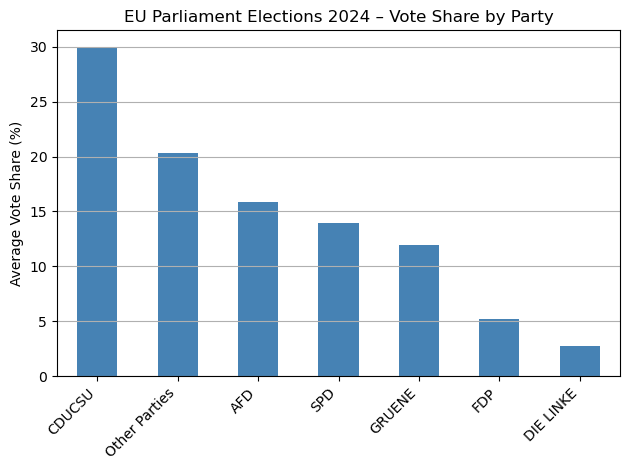

In [12]:
# 1) Make sure numeric columns really are numeric
vote_cols = ['CDUCSU', 'SPD', 'GRUENE', 'DIE LINKE', 'AFD', 'FDP', 'Other Parties']
for col in vote_cols:
    df_hist[col] = pd.to_numeric(df_hist[col].str.replace(',', '.').str.replace('%', ''), errors='coerce')

# 2) Filter for the 2024 election
df_2024 = df_hist[df_hist['Election Year'] == 2024].copy()

print(f"Rows for 2024: {len(df_2024)}")

# 3) National average vote share per party
shares_2024 = df_2024[vote_cols].mean().sort_values(ascending=False)
print("\nAverage national vote share (2024):")
print(shares_2024)

# 4) Bar chart
shares_2024.plot(kind='bar', color='steelblue')
plt.title('EU Parliament Elections 2024 – Vote Share by Party')
plt.ylabel('Average Vote Share (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 🗺️ Load and Prepare Geographic Data (District Level)

To visualise the election results geographically, this section loads the **district shapefile** (`VG2500_KRS.shp`) and the **district-level vote count data** (`ewkr24_umrechnung_ew19.csv`).  
The shapefile provides the geographic boundaries of all German electoral districts, while the CSV file contains the corresponding voting results for each district.

Both datasets are cleaned and aligned using their unique district identifiers (`AGS` codes) to ensure a correct spatial join between **geographic regions** and **election data**.  
This creates the foundation for all subsequent **choropleth maps** and spatial analyses.


In [62]:
# --- district geometry (Kreise) ---
shapefile_path = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/VG2500_KRS.shp'
kreise = gpd.read_file(shapefile_path)
kreise['AGS'] = kreise['AGS'].astype(str).str.zfill(5)

# --- district-level vote counts ---
votes_path = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ewkr24_umrechnung_ew19.csv'
df_votes = pd.read_csv(votes_path, sep=';', dtype={'District': str}, low_memory=False)
df_votes['District'] = df_votes['District'].str.strip().str.zfill(5)

print("Loaded:", len(kreise), "district polygons  |", len(df_votes), "vote rows")


Loaded: 400 district polygons  | 402 vote rows


# 🧾 Read 2024 EU Election Results per District

In this section, we load the **district-level results** of the 2024 European Parliament elections in Germany.  
Each row in the dataset represents one electoral district and contains the **number of votes per political party**.

The cleaning process includes:
1. **Reading and formatting** the CSV file (`ewkr24_umrechnung_ew19.csv`) using consistent district identifiers (`District` codes padded to 5 digits).  
2. **Checking data integrity** by counting rows, unique districts, and duplicate entries.  
3. **Detecting and normalizing** party columns — if raw vote counts are used, they are converted into **relative vote shares (0–1)** so that the results are comparable across districts.

This ensures the dataset is clean, consistent, and ready for merging with geographic boundaries to visualize district-level voting patterns.


In [14]:
# Votes per party & district (semicolon-separated)
path_votes = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ewkr24_umrechnung_ew19.csv'

# Load
df_votes = pd.read_csv(path_votes, sep=';', dtype={'District': 'string'}, low_memory=False)
df_votes.columns = df_votes.columns.str.strip()
df_votes['District'] = df_votes['District'].str.strip().str.zfill(5)

# Integrity snapshot
print("Rows:", len(df_votes), "| Unique Districts:", df_votes['District'].nunique())
print("Duplicate rows:", df_votes.duplicated().sum(), "| Duplicate District IDs:", df_votes['District'].duplicated().sum())

# Optional: infer party columns & normalize to shares (0..1) if you have raw counts
non_party = {'District', 'Eligible', 'Valid', 'Total', 'Wahlberechtigte', 'Gueltige', 'Summe'}
party_cols = [c for c in df_votes.columns 
              if c not in non_party and pd.api.types.is_numeric_dtype(df_votes[c])]

if party_cols:
    row_sum = df_votes[party_cols].sum(axis=1)
    # Heuristic: if any row sums > 1.5, assume counts/percentages → rescale to proportions
    if (row_sum > 1.5).any():
        df_votes_norm = df_votes.copy()
        df_votes_norm[party_cols] = df_votes_norm[party_cols].div(row_sum.replace(0, np.nan), axis=0)
        print(f"Normalized {len(party_cols)} party columns to shares (0..1).")
    else:
        df_votes_norm = df_votes.copy()
        print("Party columns appear to be already proportions (sum≈1).")
else:
    df_votes_norm = df_votes.copy()
    print("No numeric party columns detected; check schema.")

# Preview
display(df_votes_norm.head())


Rows: 402 | Unique Districts: 402
Duplicate rows: 0 | Duplicate District IDs: 0
Normalized 44 party columns to shares (0..1).


,Land,District,Name,Eligible Voters,Voters,Invalid,Valid,CDU,GRÜNE,SPD,...,MENSCHLICHE WELT,LIEBE,DIE VIOLETTEN,DIE DIREKTE!,DIE RECHTE,DKP,MLPD,NL,III. Weg,SGP
0,SH,01001,"Flensburg, Stadt",0.470402,0.264799,0.001583,39410,0.045610,0.097532,0.037910,...,0.000267,0.000254,0.000267,0.000220,0.000127,0.000094,0.000087,0.000160,0.000047,0.000100
1,SH,01002,"Kiel, Landeshauptstadt",0.459304,0.270348,0.001423,109018,0.045169,0.099471,0.044183,...,0.000244,0.000175,0.000207,0.000158,0.000091,0.000168,0.000104,0.000153,0.000022,0.000030
2,SH,01003,"Lübeck, Hansestadt",0.477955,0.261023,0.001323,90485,0.052855,0.082179,0.050416,...,0.000195,0.000278,0.000224,0.000161,0.000115,0.000141,0.000115,0.000155,0.000037,0.000017
3,SH,01004,"Neumünster, Stadt",0.509058,0.245471,0.001953,28805,0.059508,0.066017,0.044688,...,0.000144,0.000237,0.000178,0.000211,0.000101,0.000093,0.000076,0.000118,0.000051,0.000025
4,SH,01051,Dithmarschen,0.478878,0.260561,0.002125,57769,0.080324,0.054225,0.046051,...,0.000242,0.000291,0.000210,0.000143,0.000170,0.000098,0.000058,0.000103,0.000058,0.000054


In [ ]:
# Visualize Ballots Cast per District

To understand the geographic distribution of **voter participation**, this section visualizes the total number of **ballots cast** in the 2024 European Parliament elections across all German districts.

Steps:
1. Select the numeric column representing the **actual number of voters** (`Voters` or `Valid`, depending on the dataset).  
2. Merge the voting data with the **district shapefile** (`kreise`) to attach participation figures to geographic areas.  
3. Handle missing values by setting empty counts to zero.  
4. Create a **choropleth heat map** showing the intensity of voting activity, where darker regions represent districts with higher voter turnout.

This visualization helps identify regions with higher or lower electoral participation, providing a foundation for later comparisons of voting patterns and political preferences.


Districts with no vote count: 0


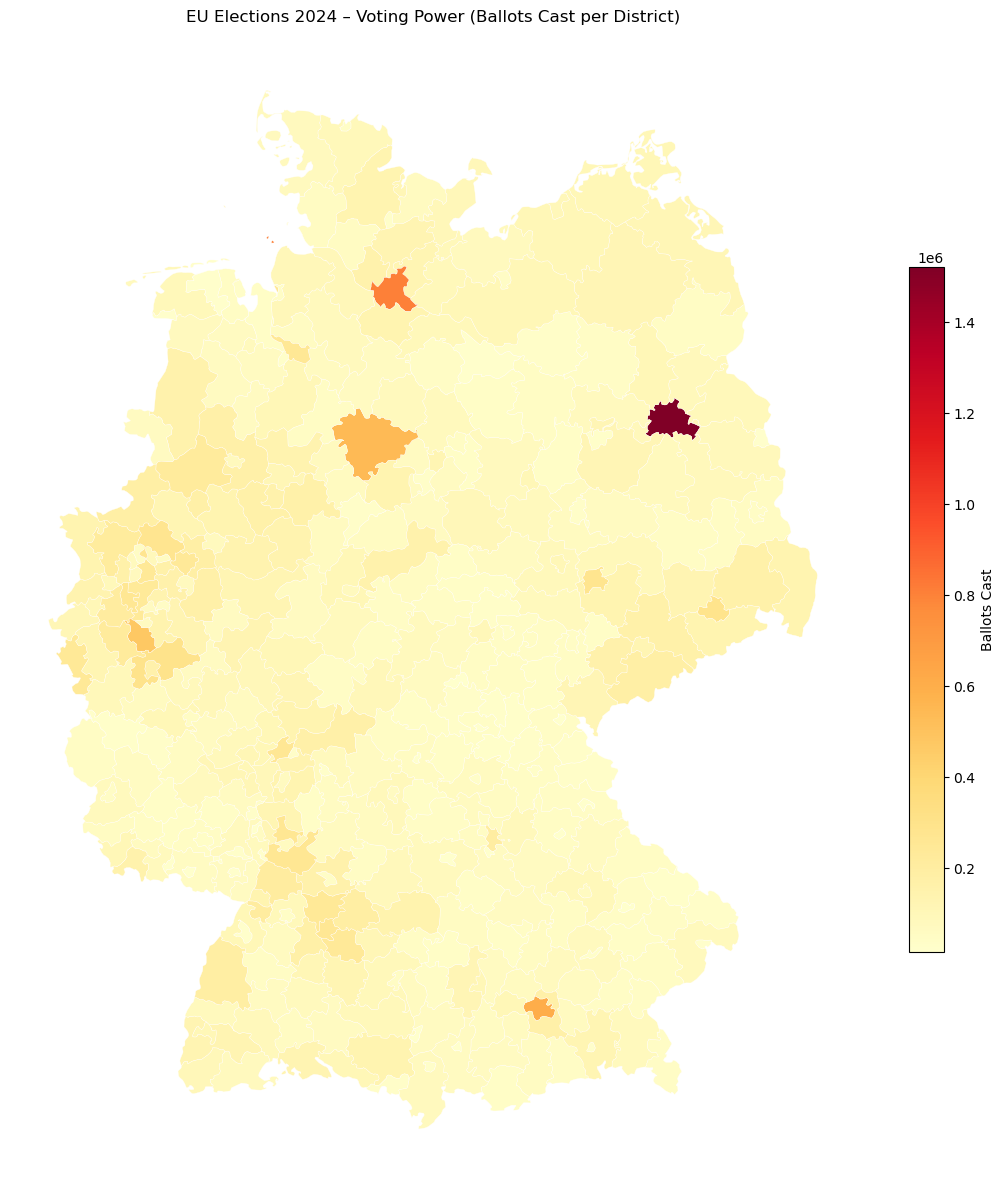

In [15]:
# ------------------------------------------------------------------
# 2) Choose the numeric column that represents “ballots actually cast”.
#    Use 'Voters' if that column exists in df_votes; otherwise try 'Valid'.
vote_count_col = 'Voters'          # change if your file calls it 'Valid'

# ------------------------------------------------------------------
# 3) Join counts onto geometry
gdf_pop = kreise.merge(df_votes[['District', vote_count_col]],
                       left_on='AGS', right_on='District', how='left')

missing = gdf_pop[vote_count_col].isna().sum()
print(f"Districts with no vote count: {missing}")

gdf_pop[vote_count_col] = gdf_pop[vote_count_col].fillna(0)

# ------------------------------------------------------------------
# 4) Plot heat-map
fig, ax = plt.subplots(figsize=(11, 12))
gdf_pop.plot(column=vote_count_col,
             cmap='YlOrRd',
             linewidth=0.25,
             edgecolor='white',
             legend=True,
             legend_kwds={'label': 'Ballots Cast', 'shrink': 0.6},
             ax=ax)
ax.set_title('EU Elections 2024 – Voting Power (Ballots Cast per District)', pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


# Visualise Geographic Election Data

In this section, we prepare the datasets for **geographic visualisation** of election results.  
Unlike postal codes, electoral district boundaries in Germany are represented by official **administrative area identifiers** (`AGS` codes).  
These codes are used to link the **voting data** with the **spatial shapefile** of districts (`VG2500_KRS`), enabling accurate regional mapping.

Steps performed:
1. **Align unique identifiers** (`AGS` and `District`) by ensuring both are 5-digit strings.  
2. **Identify and normalize party vote columns** to express results as **vote shares (0–1)**.  
3. **Determine each district’s winner and runner-up**, including the *non-winner share* and *winning margin*.  
4. **Merge** this enriched dataset with the geographic boundaries to create `GeoDataFrames` (`gdf_win`, `gdf_share`) ready for plotting.

The resulting data structure allows for detailed **choropleth mapping**, highlighting both winning parties and the relative strength of competition across districts.


In [18]:
# 0) Keys aligned
df_votes['District'] = df_votes['District'].astype('string').str.strip().str.zfill(5)
kreise['AGS'] = kreise['AGS'].astype('string').str.strip().str.zfill(5)

# 1) Infer party columns (numeric, excluding obvious non-party totals)
non_party = {'District','Eligible','Valid','Total','Wahlberechtigte','Gueltige','Summe'}
party_cols = [c for c in df_votes.columns if c not in non_party and pd.api.types.is_numeric_dtype(df_votes[c])]
print("Party columns:", party_cols)

# 2) Normalize to proportions per district if needed
row_sum = df_votes[party_cols].sum(axis=1)
votes_share = df_votes.copy()
if (row_sum > 1.5).any():  # counts or percentages -> rescale
    votes_share[party_cols] = votes_share[party_cols].div(row_sum.replace(0, np.nan), axis=0)
elif votes_share[party_cols].max().max() > 1:  # percentages 0..100
    votes_share[party_cols] = votes_share[party_cols] / 100.0

# 3) Winner & runner-up per district
long = votes_share[['District'] + party_cols].melt(id_vars='District', var_name='party', value_name='share')
long_sorted = long.sort_values(['District','share'], ascending=[True, False])

winner = (long_sorted.groupby('District').head(1)
          .rename(columns={'party':'winner_party', 'share':'winner_share'}))[['District','winner_party','winner_share']]
runner = (long_sorted.groupby('District').nth(1).reset_index()
          .rename(columns={'party':'runnerup_party', 'share':'runnerup_share'}))[['District','runnerup_party','runnerup_share']]

leaders = winner.merge(runner, on='District', how='left')
leaders['non_winner_share'] = 1 - leaders['winner_share']
leaders['winner_margin'] = leaders['winner_share'] - leaders['runnerup_share']

# 4) Geo join for plotting
gdf_win = kreise.merge(leaders, left_on='AGS', right_on='District', how='left')
gdf_share = kreise.merge(votes_share[['District'] + party_cols], left_on='AGS', right_on='District', how='left')

print("Join coverage (winners):", gdf_win['District'].notna().mean())


Party columns: ['Eligible Voters', 'Voters', 'Invalid', 'CDU', 'GRÜNE', 'SPD', 'AFD', 'CSU', 'DIE LINKE', 'FDP', 'Die PARTEI', 'FREIE WÄHLER', 'Tierschutzpartei', 'ÖDP', 'FAMILIE', 'VOLT', 'PIRATEN', 'MERA25', 'HEIMAT', 'TIERSCHUTZ hier!', 'PARTEI FÜR DIE TIERE', 'BP', 'Graue Panther', 'Die Grauen', 'Verjüngungsforschung', 'BIG', 'Tierschutzallienz', 'Bündnis C', 'Die Humanisten', 'Volksabstimmung', 'DIE FRAUEN', 'LKR', 'BGE', 'ÖkoLinX', 'MENSCHLICHE WELT', 'LIEBE', 'DIE VIOLETTEN', 'DIE DIREKTE!', 'DIE RECHTE', 'DKP', 'MLPD', 'NL', 'III. Weg', 'SGP']
Join coverage (winners): 1.0


In [ ]:
# Visualize District-Level Election Results

This section combines the **geographic district data** with the **election results** to visualize how voting outcomes vary across Germany.

Steps performed:
1. **Load geometry and election data** – the district shapefile (`VG2500_KRS.shp`) provides the boundaries, and the CSV file contains the voting results per district.  
2. **Normalize vote shares** – convert raw counts or percentages into comparable proportions (0–1) across all districts.  
3. **Identify winners and runners-up** – determine which party received the most and second-most votes in each district, along with the winning margin.  
4. **Merge** this information with geographic boundaries to prepare for plotting.  
5. **Visualize** the results:
   - A **baseline “winner map”** showing which party won each district using distinct party colors.  
   - A **vote-share map** (e.g., for the SPD) illustrating relative party strength across regions.

These visualizations highlight the **regional polarization and clustering of political support**, providing a first spatial understanding of electoral patterns across Germany.


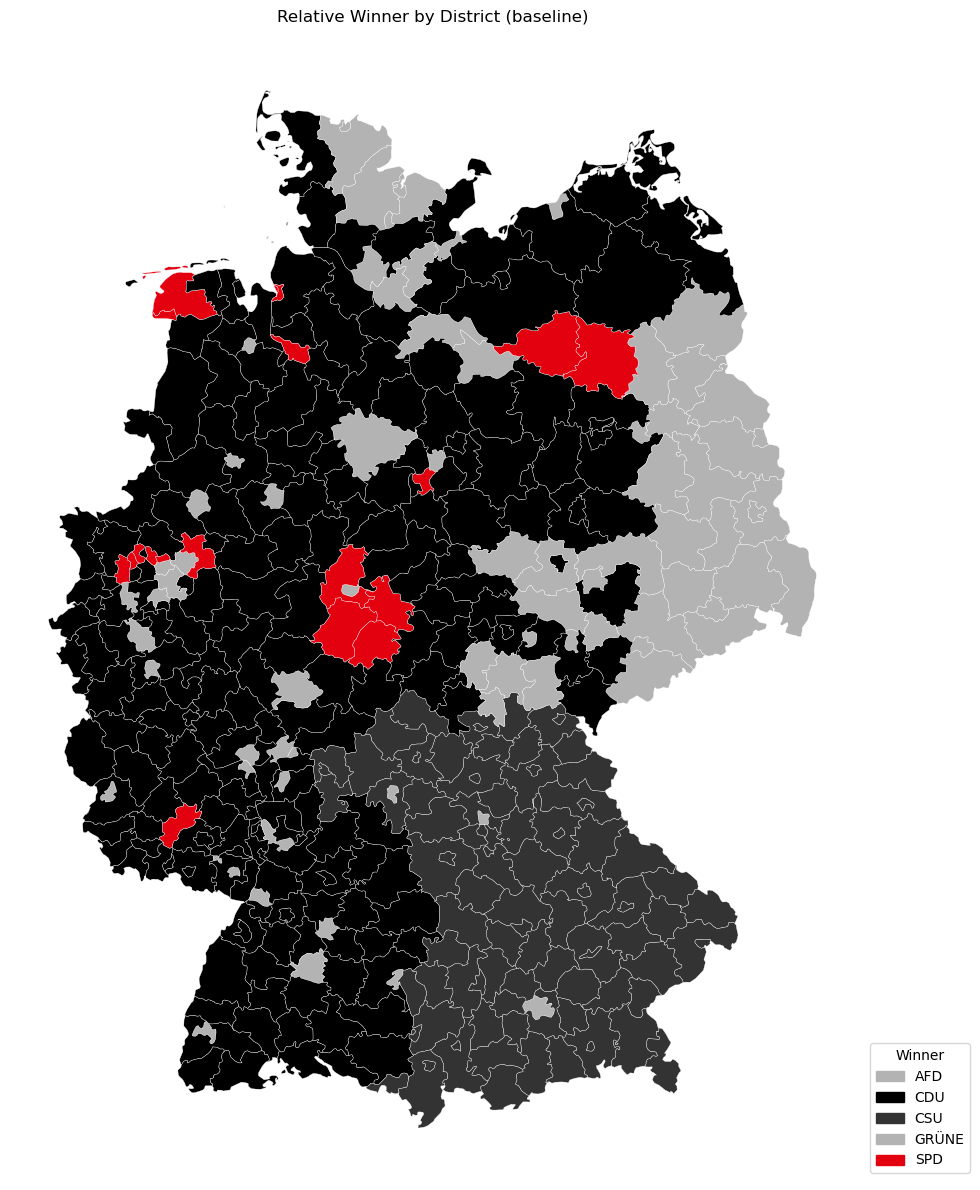

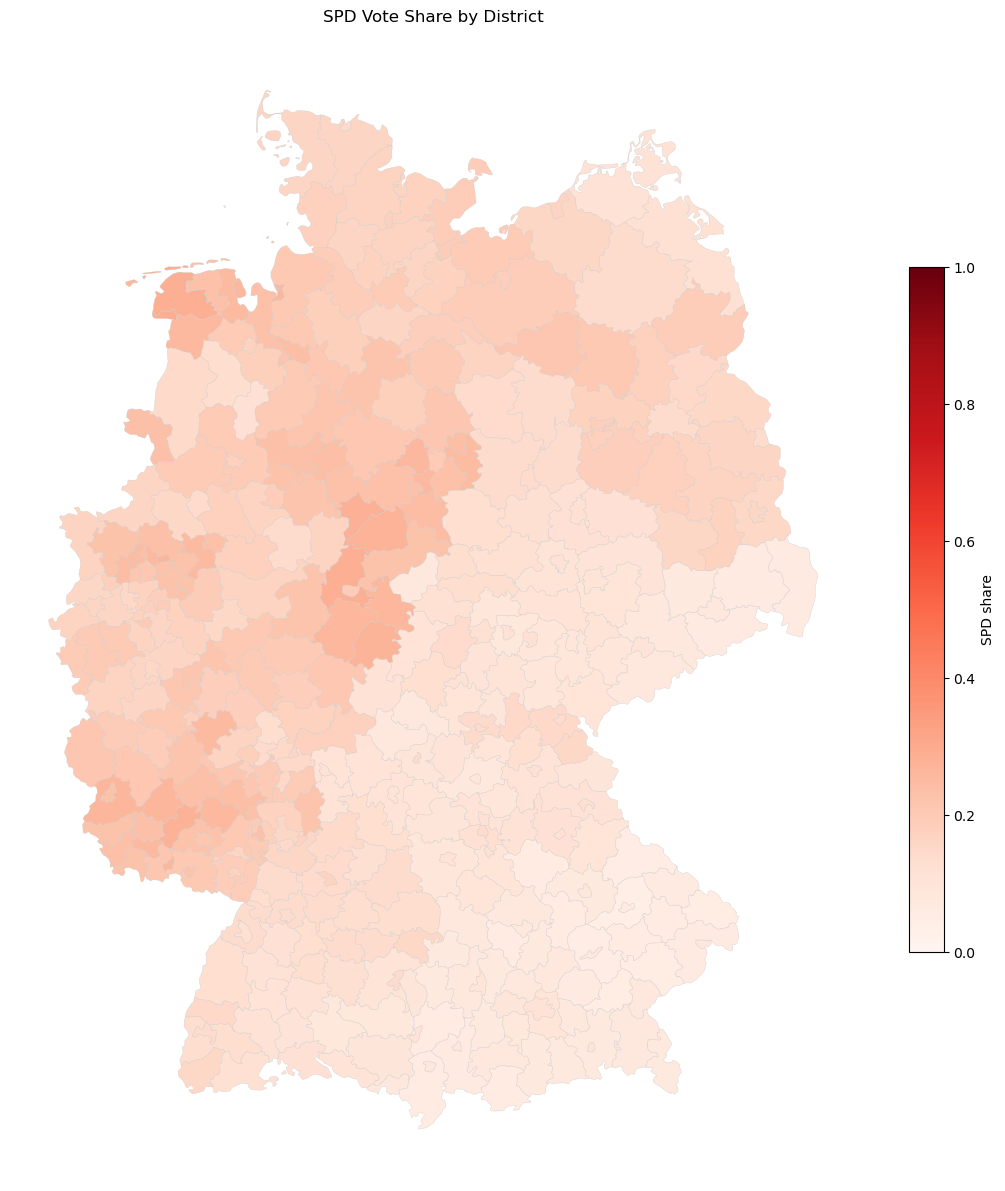

In [19]:
# ------------------------------------------------------------
# 0) Paths (adjust if your files live elsewhere)
shp = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/VG2500_KRS.shp'
csv = r'/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ewkr24_umrechnung_ew19.csv'

# ------------------------------------------------------------
# 1) Load geometry and votes
kreise = gpd.read_file(shp)
kreise['AGS'] = kreise['AGS'].astype(str).str.strip().str.zfill(5)

df_votes = pd.read_csv(csv, sep=';', dtype={'District': str}, low_memory=False)
df_votes['District'] = df_votes['District'].str.strip().str.zfill(5)

# ------------------------------------------------------------
# 2) Normalise to vote shares (detect numeric party columns)
non_party = {'District', 'Eligible Voters', 'Voters', 'Invalid', 'Valid'}
party_cols = [c for c in df_votes.columns
              if c not in non_party and pd.api.types.is_numeric_dtype(df_votes[c])]

# Convert commas to dots, then to numeric
for c in party_cols:
    df_votes[c] = pd.to_numeric(df_votes[c].astype(str).str.replace(',', '.'),
                                errors='coerce')

row_sum = df_votes[party_cols].sum(axis=1)
df_votes[party_cols] = df_votes[party_cols].div(row_sum.replace(0, pd.NA), axis=0)

# ------------------------------------------------------------
# 3) Long format → winner / runner-up
long = df_votes[['District'] + party_cols].melt(
    id_vars='District', var_name='party', value_name='share'
)
long = long.sort_values(['District', 'share'], ascending=[True, False])

winner = (long.groupby('District').head(1)
          .rename(columns={'party': 'winner_party', 'share': 'winner_share'}))
runner = (long.groupby('District').nth(1).reset_index()
          .rename(columns={'party': 'runnerup_party', 'share': 'runnerup_share'}))

leaders = winner.merge(runner, on='District', how='left')
leaders['non_winner_share'] = 1 - leaders['winner_share']
leaders['winner_margin']   = leaders['winner_share'] - leaders['runnerup_share']

# ------------------------------------------------------------
# 4) Geo joins
gdf_share = kreise.merge(df_votes[['District'] + party_cols],
                         left_on='AGS', right_on='District', how='left')

gdf_win = kreise.merge(leaders,
                       left_on='AGS', right_on='District', how='left')

# ------------------------------------------------------------
# 5) Plot baseline winner map
party_colors = {
    'CDU': '#000000', 'CSU': '#333333', 'CDU/CSU': '#000000',
    'SPD': '#E3000F',
    'GRUENE': '#64A12D', 'Grüne': '#64A12D', 'B90/Grüne': '#64A12D',
    'AfD': '#009EE0',
    'FDP': '#FFED00',
    'DIE LINKE': '#BE3075', 'Linke': '#BE3075',
    'BSW': '#8E44AD',
    'Sonstige': '#B3B3B3', 'Other': '#B3B3B3'
}

gdf_win['winner_color'] = gdf_win['winner_party'].map(party_colors).fillna('#B3B3B3')

fig, ax = plt.subplots(figsize=(11, 12))
gdf_win.plot(ax=ax, color=gdf_win['winner_color'],
             edgecolor='white', linewidth=0.25)
ax.set_title('Relative Winner by District (baseline)', pad=12)
ax.set_axis_off()

handles = [mpatches.Patch(color=party_colors.get(p, '#B3B3B3'), label=p)
           for p in sorted(gdf_win['winner_party'].dropna().unique())]
ax.legend(handles=handles, title='Winner', loc='lower left',
          frameon=True, bbox_to_anchor=(1.01, 0))
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6) Example: vote-share map for one party
party = 'SPD'   # change to any party in party_cols for other maps

fig, ax = plt.subplots(figsize=(11, 12))
gdf_share.plot(column=party, ax=ax, cmap='Reds',
               edgecolor='0.8', linewidth=0.25,
               legend=True, vmin=0, vmax=1,
               legend_kwds={'label': f'{party} share', 'shrink': 0.6})
ax.set_title(f'{party} Vote Share by District', pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


# Join Geodata and Votes + Harmonize Party Names

This section prepares the election results for spatial analysis by making the **tabular vote data** compatible with the **district geometry**.

**What we do**
1. **Key alignment:** Ensure both IDs are 5-digit strings (`AGS` in geometry, `District` in votes).  
2. **Integrity check:** Compare coverage (e.g., 400 polygons vs. 402 vote rows) and list any unmatched codes on either side.  
3. **Party column canonization:** Map many label variants to a **canonical party set**  
   (e.g., `GRÜNE`, `B90/GRUENE` → `Gruene`; `CDU/CSU` → combine into `CDU`).  
4. **Normalize to shares:** Convert raw counts/percentages to **proportions (0–1)** per district so results are comparable.  
5. **Winners & competition:** For each district, compute  
   - `winner_party`, `winner_share`  
   - `runnerup_party`, `runnerup_share`  
   - `winner_margin = winner_share − runnerup_share`  
   - `non_winner_share = 1 − winner_share`  
6. **Geo joins:** Create `gdf_share` (vote shares per party) and `gdf_win` (winner/runner stats) for mapping.

**Visuals produced**
- **SPD vote share (continuous color scale):** Highlights regional strength patterns using a perceptually smooth colormap.  
- **Non-winner share (TwoSlopeNorm centered at 50%):** Blue shades emphasize districts where **a majority did not vote** for the relative winner.  

**Quick insights**
- The **SPD share map** reveals clear geographic clustering (e.g., stronger pockets vs. weaker regions).  
- The **non-winner share map** explains why simple winner maps mislead: in many districts, the winner’s support is **< 50%**, so most voters preferred someone else.


In [20]:
# both sides should be 5-char strings already (you did zfill)
print('kreise rows:', len(kreise))
print('df_votes rows:', df_votes['District'].nunique())

unmatched_geo = kreise.loc[~kreise['AGS'].isin(df_votes['District']), ['AGS','GEN']]
unmatched_tab = df_votes.loc[~df_votes['District'].isin(kreise['AGS']), ['District']].drop_duplicates()

print('Districts in geo but not in votes:', len(unmatched_geo))
print('Districts in votes but not in geo:', len(unmatched_tab))


kreise rows: 400
df_votes rows: 402
Districts in geo but not in votes: 0
Districts in votes but not in geo: 2


In [22]:
# Map many variants -> canonical names you’ll use later
variant_map = {
    # Greens
    'GRUENE':'Gruene', 'GRÜNE':'Gruene', 'GRÜNEN':'Gruene',
    'B90/GRÜNE':'Gruene', 'BÜNDNIS 90/DIE GRÜNEN':'Gruene', 'B90/GRUENE':'Gruene', 'GRUENEN':'Gruene',
    # AfD
    'AFD':'AfD', 'ALTERNATIVE FÜR DEUTSCHLAND':'AfD', 'ALTERNATIVE FUER DEUTSCHLAND':'AfD',
    # FDP
    'FDP':'FDP', 'FREIE DEMOKRATEN':'FDP',
    # CDU/CSU (we’ll combine to CDU)
    'CDU':'CDU', 'CSU':'CSU', 'CDU/CSU':'CDU_CSU',
    # SPD
    'SPD':'SPD', 'SOZIALDEMOKRATISCHE PARTEI DEUTSCHLANDS':'SPD',
    # Linke/BSW/others (optional, include if present)
    'DIE LINKE':'Linke', 'LINKE':'Linke',
    'BSW':'BSW', 'BÜNDNIS SAHRA WAGENKNECHT':'BSW',
    # Others bucket
    'SONSTIGE':'Other', 'SONSTIG':'Other', 'OTHER':'Other', 'OTHERS':'Other'
}

def canon(col):
    # normalize column name for matching
    c = re.sub(r'\s+', ' ', str(col)).strip()
    c = c.replace(',', '.')
    up = c.upper()
    return variant_map.get(up, None)

# Find numeric party-like columns
non_party = set(['District','Eligible Voters','Voters','Invalid','Valid','AGS','GEN'])
numeric_cols = [c for c in df_votes.columns if c not in non_party and pd.api.types.is_numeric_dtype(df_votes[c])]

# Build a rename dict for columns we recognize
rename = {}
for c in numeric_cols:
    tag = canon(c)
    if tag: 
        rename[c] = tag

# Apply renaming
df_votes_ren = df_votes.rename(columns=rename).copy()

# Combine CDU + CSU if both exist
if 'CDU' in df_votes_ren.columns and 'CSU' in df_votes_ren.columns:
    df_votes_ren['CDU'] = df_votes_ren['CDU'].fillna(0) + df_votes_ren['CSU'].fillna(0)
    df_votes_ren.drop(columns=['CSU'], inplace=True)

# If a combined CDU_CSU exists, merge it into CDU
if 'CDU_CSU' in df_votes_ren.columns:
    df_votes_ren['CDU'] = df_votes_ren.get('CDU', 0).fillna(0) + df_votes_ren['CDU_CSU'].fillna(0)
    df_votes_ren.drop(columns=['CDU_CSU'], inplace=True)

# Recompute party list from what’s actually present
party_cols = [p for p in ['CDU','SPD','Gruene','AfD','FDP','Linke','BSW','Other'] if p in df_votes_ren.columns]
print("Using party columns:", party_cols)

# Ensure District is 5-char string
df_votes_ren['District'] = df_votes_ren['District'].astype(str).str.strip().str.zfill(5)

# If values are counts, convert to shares (0–1)
if df_votes_ren[party_cols].max().max() > 1.0:
    row_sum = df_votes_ren[party_cols].sum(axis=1).replace(0, np.nan)
    df_votes_ren[party_cols] = df_votes_ren[party_cols].div(row_sum, axis=0)


Using party columns: ['CDU', 'SPD', 'Gruene', 'AfD', 'FDP', 'Linke']


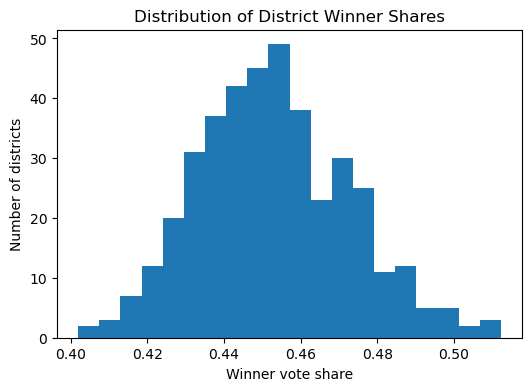

In [23]:
leaders['winner_share'].plot.hist(bins=20, figsize=(6,4))
plt.xlabel('Winner vote share'); plt.ylabel('Number of districts')
plt.title('Distribution of District Winner Shares')
plt.show()


In [23]:
# Long -> winner/runner
long = df_votes_ren[['District'] + party_cols].melt(
    id_vars='District', var_name='party', value_name='share'
).sort_values(['District','share'], ascending=[True, False])

winner = (long.groupby('District').head(1)
          .rename(columns={'party':'winner_party','share':'winner_share'}))
runner = (long.groupby('District').nth(1).reset_index()
          .rename(columns={'party':'runnerup_party','share':'runnerup_share'}))

leaders = winner.merge(runner, on='District', how='left')
leaders['non_winner_share'] = 1 - leaders['winner_share']
leaders['winner_margin']    = leaders['winner_share'] - leaders['runnerup_share']

# Geo joins (kreise must already be loaded; ensure AGS is 5-char)
kreise['AGS'] = kreise['AGS'].astype(str).str.strip().str.zfill(5)

gdf_share = kreise.merge(
    df_votes_ren[['District'] + party_cols],
    left_on='AGS', right_on='District', how='left'
)

gdf_win = kreise.merge(
    leaders[['District','winner_party','winner_share','runnerup_party','runnerup_share','non_winner_share']],
    left_on='AGS', right_on='District', how='left'
)


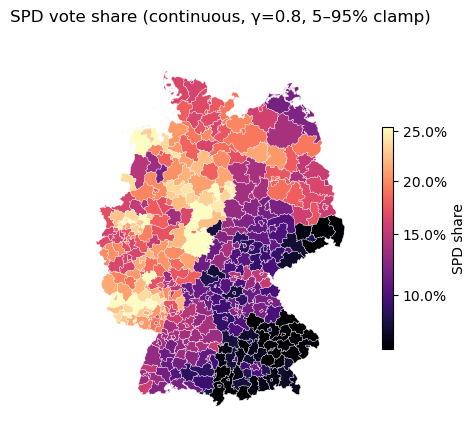

In [27]:
vals = gdf_share['SPD'].astype(float).to_numpy()
vmin, vmax = np.nanpercentile(vals, [5, 95])
norm = PowerNorm(gamma=0.8, vmin=vmin, vmax=vmax)

ax = gdf_share.plot(
    column='SPD',
    cmap='magma',
    norm=norm,                # continuous scaling = colorbar
    linewidth=0.25, edgecolor='white',
    legend=True,
    legend_kwds={'label': 'SPD share', 'shrink': 0.6}  # no 'format' here
)

# Now grab the colorbar and format ticks as percent
cb = ax.get_figure().axes[-1]  # colorbar axis
cb.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title('SPD vote share (continuous, γ=0.8, 5–95% clamp)', pad=12)
ax.set_axis_off()



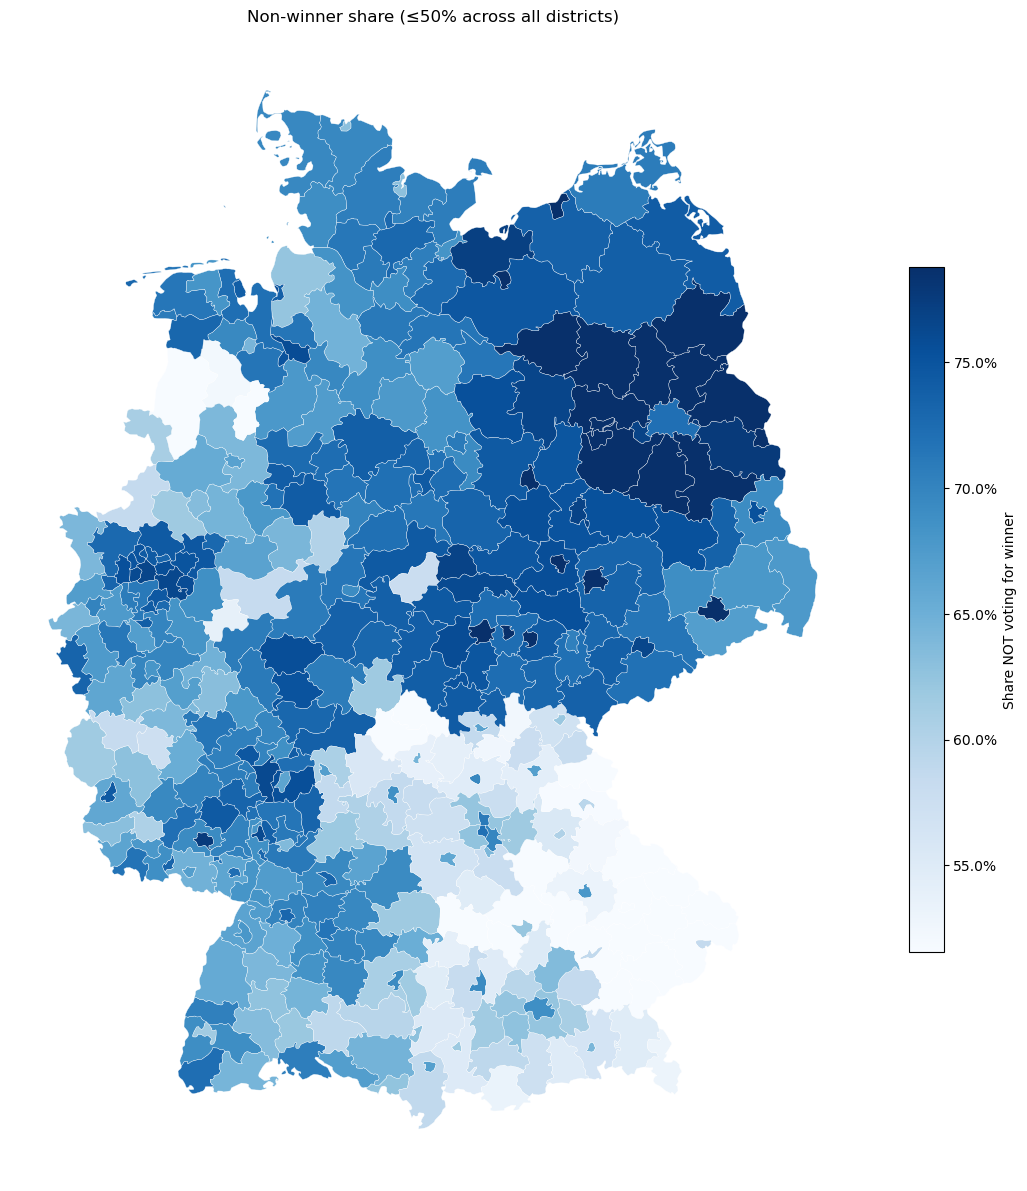

In [33]:
vals = gdf_win['non_winner_share'].astype(float).to_numpy()
vals = vals[~np.isnan(vals)]
lo, hi = np.nanpercentile(vals, [5, 95])

fig, ax = plt.subplots(figsize=(11, 12))  # single figure/axes

if (lo < 0.5) and (hi > 0.5):
    norm = TwoSlopeNorm(vmin=lo, vcenter=0.50, vmax=hi)
    cmap = 'RdBu_r'
    title = 'Non-winner share (centered at 50%)'
else:
    norm = Normalize(vmin=lo, vmax=hi)
    cmap = 'Blues'
    side = "≥50%" if np.nanmin(vals) >= 0.5 else "≤50%"
    title = f'Non-winner share ({side} across all districts)'

# IMPORTANT: pass ax=ax so it uses the same figure
gdf_win.plot(
    column='non_winner_share',
    cmap=cmap, norm=norm,
    linewidth=0.25, edgecolor='white',
    legend=True, legend_kwds={'label': 'Share NOT voting for winner', 'shrink': 0.6},
    ax=ax
)

# format colorbar as percent (colorbar axis is the last one in the figure)
cb = fig.axes[-1]
cb.yaxis.set_major_formatter(PercentFormatter(1))

ax.set_title(title, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
## Why a winner-only map is misleading

The map below shows the **share of voters who did *not* vote for the district winner**.  
In most districts, **well over 50%** of voters chose other parties; in many places the non-winner share is **65–75%**.  
This demonstrates that a simple winner map visually exaggerates dominance: it hides the fact that the winner is often a **plurality, not a majority**.


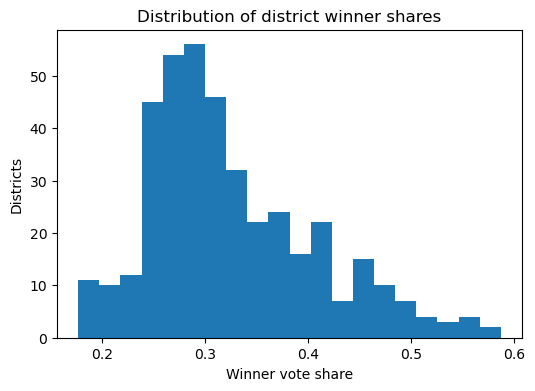

In [34]:
leaders['winner_share'].plot.hist(bins=20, figsize=(6,4))
plt.xlabel('Winner vote share'); plt.ylabel('Districts')
plt.title('Distribution of district winner shares')
plt.show()


In [ ]:
### Distribution of district winner shares

The histogram shows that winners typically receive **~30–45%** of votes, with very few districts approaching an absolute majority.  
In other words, in the vast majority of districts **most voters supported someone else**, which explains the large non-winner areas on the previous map.


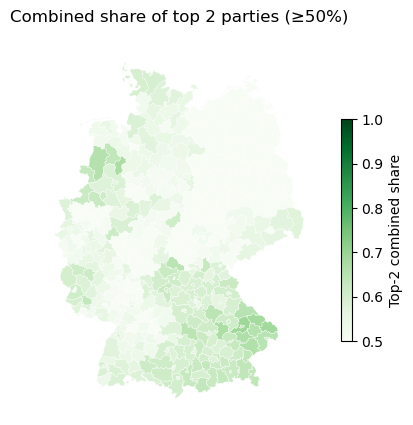

In [35]:
leaders['top2_share'] = leaders['winner_share'] + leaders['runnerup_share']
gdf_top2 = kreise.merge(leaders[['District','top2_share']],
                        left_on='AGS', right_on='District', how='left')

ax = gdf_top2.plot(column='top2_share', cmap='Greens',
                   vmin=0.5, vmax=1.0,
                   linewidth=0.25, edgecolor='white',
                   legend=True, legend_kwds={'label':'Top-2 combined share','shrink':0.6})
ax.set_title('Combined share of top 2 parties (≥50%)')
ax.set_axis_off()


In [ ]:
### Top-2 parties better reflect voter coalitions

Mapping the **combined share of the top two parties** provides a more faithful picture of local preferences.  
Across many districts the top-2 share exceeds **50–60%**, indicating that realistic governing or representational coalitions often arise from **two leading parties**, not just the relative winner alone.


In [74]:
# 0) Ensure keys are 5-char strings
df_votes['District'] = df_votes['District'].astype(str).str.strip().str.zfill(5)
kreise['AGS'] = kreise['AGS'].astype(str).str.strip().str.zfill(5)

# 1) Map column name variants -> canonical party names
variant_map = {
    # Greens
    'GRUENE':'Gruene','GRÜNE':'Gruene','GRÜNEN':'Gruene','B90/GRÜNE':'Gruene',
    'BÜNDNIS 90/DIE GRÜNEN':'Gruene','B90/GRUENE':'Gruene','GRUENEN':'Gruene',
    # AfD
    'AFD':'AfD','ALTERNATIVE FÜR DEUTSCHLAND':'AfD','ALTERNATIVE FUER DEUTSCHLAND':'AfD',
    # FDP
    'FDP':'FDP','FREIE DEMOKRATEN':'FDP',
    # CDU/CSU
    'CDU':'CDU','CSU':'CSU','CDU/CSU':'CDU_CSU',
    # SPD
    'SPD':'SPD','SOZIALDEMOKRATISCHE PARTEI DEUTSCHLANDS':'SPD',
    # Linke / BSW / Other
    'DIE LINKE':'Linke','LINKE':'Linke',
    'BSW':'BSW','BÜNDNIS SAHRA WAGENKNECHT':'BSW',
    'SONSTIGE':'Other','SONSTIG':'Other','OTHER':'Other','OTHERS':'Other'
}

def canon(col):
    c = re.sub(r'\s+', ' ', str(col)).strip().replace(',', '.')
    return variant_map.get(c.upper(), None)

# 2) Detect numeric “party-like” columns and rename to canonical
non_party = {'District','Eligible Voters','Voters','Invalid','Valid','AGS','GEN'}
numeric_cols = [c for c in df_votes.columns
                if c not in non_party and pd.api.types.is_numeric_dtype(df_votes[c])]
rename = {c: canon(c) for c in numeric_cols if canon(c) is not None}

df_votes_ren = df_votes.rename(columns=rename).copy()

# 3) Combine CDU + CSU if both exist; also fold CDU_CSU into CDU
if 'CDU' in df_votes_ren.columns and 'CSU' in df_votes_ren.columns:
    df_votes_ren['CDU'] = df_votes_ren['CDU'].fillna(0) + df_votes_ren['CSU'].fillna(0)
    df_votes_ren.drop(columns=['CSU'], inplace=True)
if 'CDU_CSU' in df_votes_ren.columns:
    df_votes_ren['CDU'] = df_votes_ren.get('CDU', 0).fillna(0) + df_votes_ren['CDU_CSU'].fillna(0)
    df_votes_ren.drop(columns=['CDU_CSU'], inplace=True)

# 4) Keep only parties we’ll analyze (present in data)
party_cols = [p for p in ['CDU','SPD','Gruene','AfD','FDP','Linke','BSW','Other']
              if p in df_votes_ren.columns]

# 5) Convert counts/percent to shares (0..1) if needed
if len(party_cols) > 0:
    row_sum = df_votes_ren[party_cols].sum(axis=1).replace(0, np.nan)
    if df_votes_ren[party_cols].max().max() > 1.0:
        # either raw counts or 0..100 percentages -> normalize per row
        df_votes_ren[party_cols] = df_votes_ren[party_cols].div(row_sum, axis=0)

# 6) Final key formatting
df_votes_ren['District'] = df_votes_ren['District'].astype(str).str.strip().str.zfill(5)

print("df_votes_ren ready. Parties:", party_cols)

df_votes_ren ready. Parties: ['CDU', 'SPD', 'Gruene', 'AfD', 'FDP', 'Linke']


In [ ]:
# 🧩 Part 2 — Structural Factors and Voting Outcomes

### 🎯 Research Question  
**Is there a connection between regional structural data and which party obtains the relative or absolute majority?**  

To explore this, we integrate **district-level socio-economic indicators** with **EU election results (2024)** and examine how structural variables — such as **income, unemployment, education, and population density** — relate to party performance.

---

### 🧮 Data Sources  
1. **EU Election Results per District (`ewkr24_umrechnung_ew19.csv`)** — containing vote shares for all major parties (SPD, CDU, AfD, Greens, FDP, etc.) across 402 German districts.  
2. **Structural Data (`ew24_structure_data.xlsx`)** — providing district-level indicators:
   - Disposable income (EUR per inhabitant)  
   - Unemployment rate (October 2023)  
   - Share of school graduates with higher education entrance qualification  
   - Population density (inhabitants per km²)

Both datasets were merged using the **district code (`District`)** as a unique key, ensuring one-to-one correspondence between geography and structure.

---

### 🧠 Methodological Approach  
To analyze the connection between socio-economic conditions and electoral outcomes, several analytical methods were applied:

- **Data alignment and cleaning:**  
  Standardizing formats, converting textual values to numeric (handling commas and missing entries).  

- **Descriptive statistics:**  
  Understanding the distribution and variability of structural indicators across districts.  

- **LOWESS scatterplots:**  
  Exploring non-linear relationships between each structural factor and the main parties’ vote shares (e.g., income ↔ FDP, education ↔ Greens).  

- **OLS regression models:**  
  Quantifying how each socio-economic variable affects continuous vote shares for key parties (SPD, AfD, FDP, Greens).  

- **Logistic regression (one-vs-rest):**  
  Predicting which structural factors increase the probability of a **party winning the district** relative to all others.  

---

In [77]:
# ==== Part 2: Load structural data and merge ====
struct = pd.read_excel('/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ew24_structure_data.xlsx')
struct['District'] = struct['District'].astype(str).str.strip().str.zfill(5)

dfX = df_votes_ren.merge(struct, on='District', how='inner')
print('Merged shape:', dfX.shape)
print(dfX.columns.tolist()[:15])



Merged shape: (400, 98)
['Land_x', 'District', 'Name_x', 'Eligible Voters', 'Voters', 'Invalid', 'Valid', 'CDU', 'Gruene', 'SPD', 'AfD', 'Linke', 'FDP', 'Die PARTEI', 'FREIE WÄHLER']


In [78]:
# 1) Load and align
struct = pd.read_excel(
    '/Users/alenslaskovs/Desktop/WHU/Database and Technology/Final One /EuropeanElections-2024/data/ew24_structure_data.xlsx'
)

# Ensure district code formatting is the same
struct['District'] = struct['District'].astype(str).str.strip().str.zfill(5)
df_votes_ren['District'] = df_votes_ren['District'].astype(str).str.strip().str.zfill(5)

# 2) Merge votes with structure
dfX = df_votes_ren.merge(struct, on='District', how='inner')

print('Merged shape:', dfX.shape)
print('Sample columns:', dfX.columns.tolist()[:15])


Merged shape: (400, 98)
Sample columns: ['Land_x', 'District', 'Name_x', 'Eligible Voters', 'Voters', 'Invalid', 'Valid', 'CDU', 'Gruene', 'SPD', 'AfD', 'Linke', 'FDP', 'Die PARTEI', 'FREIE WÄHLER']


In [73]:
df_votes

,Land,District,Name,Eligible Voters,Voters,Invalid,Valid,CDU,GRÜNE,SPD,AFD,CSU,DIE LINKE,FDP,Die PARTEI,FREIE WÄHLER,Tierschutzpartei,ÖDP,FAMILIE,VOLT,PIRATEN,MERA25,HEIMAT,TIERSCHUTZ hier!,PARTEI FÜR DIE TIERE,BP,Graue Panther,Die Grauen,Verjüngungsforschung,BIG,Tierschutzallienz,Bündnis C,Die Humanisten,Volksabstimmung,DIE FRAUEN,LKR,BGE,ÖkoLinX,MENSCHLICHE WELT,LIEBE,DIE VIOLETTEN,DIE DIREKTE!,DIE RECHTE,DKP,MLPD,NL,III. Weg,SGP
0,SH,01001,"Flensburg, Stadt",70431,39647,237,39410,6829,14603,5676,2477,0,2349,1988,1663,257,925,184,345,285,405,222,44,118,61,24,80,74,47,34,80,48,97,45,55,28,72,52,40,38,40,33,19,14,13,24,7,15
1,SH,01002,"Kiel, Landeshauptstadt",186195,109595,577,109018,18311,40324,17911,6459,0,6497,5270,4962,525,1488,516,599,1139,1358,675,119,197,144,38,243,180,129,129,155,85,371,85,103,110,150,198,99,71,84,64,37,68,42,62,9,12
2,SH,01003,"Lübeck, Hansestadt",166530,90946,461,90485,18416,28633,17566,6773,0,4231,4174,2680,1018,1189,456,611,935,883,332,162,214,126,48,181,121,104,213,125,97,234,77,126,73,89,97,68,97,78,56,40,49,40,54,13,6
3,SH,01004,"Neumünster, Stadt",60215,29036,231,28805,7039,7809,5286,2761,0,1041,1539,678,240,407,123,287,114,352,62,140,71,56,25,80,69,34,101,42,43,56,44,42,70,28,20,17,28,21,25,12,11,9,14,6,3
4,SH,01051,Dithmarschen,107045,58244,475,57769,17955,12121,10294,5121,0,2002,4498,1089,609,886,157,613,185,539,100,98,126,118,28,170,126,111,6,94,25,78,81,70,45,64,41,54,65,47,32,38,22,13,23,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,TH,16073,Saalfeld-Rudolstadt,88342,53882,1034,52848,12180,3328,5596,14592,0,6817,2422,1176,1355,780,217,818,162,273,91,485,188,171,55,156,178,181,29,171,62,49,193,159,68,101,34,112,99,53,127,89,58,132,15,67,9
398,TH,16074,Saale-Holzland-Kreis,68278,45101,1003,44098,11366,3183,3966,10210,0,6282,2310,877,1013,798,211,796,179,225,94,326,153,134,86,116,135,185,33,137,62,67,170,134,56,119,44,114,70,28,108,87,48,89,17,59,11
399,TH,16075,Saale-Orla-Kreis,67029,42514,884,41630,10429,2253,3791,11264,0,5713,1946,718,1136,605,216,825,145,185,66,297,161,139,75,126,134,162,13,99,92,37,122,136,45,84,29,78,68,52,99,79,58,76,19,53,5
400,TH,16076,Greiz,82940,53197,1139,52058,14559,3031,4859,13297,0,6427,2288,934,999,866,195,978,171,244,96,375,216,193,111,158,164,254,26,175,120,48,152,166,80,146,36,104,104,46,126,88,48,80,24,64,10


In [68]:
print(dfX.columns.tolist()[:30])  # check available columns
print(dfX[['District', 'CDU', 'SPD', 'Gruene', 'AfD', 'FDP']].head())


['Land_x', 'District', 'Name_x', 'Eligible Voters', 'Voters', 'Invalid', 'Valid', 'CDU', 'Gruene', 'SPD', 'AfD', 'Linke', 'FDP', 'Die PARTEI', 'FREIE WÄHLER', 'Tierschutzpartei', 'ÖDP', 'FAMILIE', 'VOLT', 'PIRATEN', 'MERA25', 'HEIMAT', 'TIERSCHUTZ hier!', 'PARTEI FÜR DIE TIERE', 'BP', 'Graue Panther', 'Die Grauen', 'Verjüngungsforschung', 'BIG', 'Tierschutzallienz']
  District    CDU    SPD  Gruene    AfD    FDP
0    01001  0.173  0.144   0.371  0.063  0.050
1    01002  0.168  0.164   0.370  0.059  0.048
2    01003  0.204  0.194   0.316  0.075  0.046
3    01004  0.244  0.184   0.271  0.096  0.053
4    01051  0.311  0.178   0.210  0.089  0.078


In [69]:
# Structural columns from your file
struct_cols = [
    'Disposable income of private households in 2021 (EUR per inhabitant)',
    'Unemployment rate in October 2023 - Total',
    'School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)',
    'Population density on 31.12.2022 (inhabitants per km2)'
]

# Quick overview
desc = dfX[struct_cols].describe().T
display(desc)


,count,mean,std,min,25%,50%,75%,max
Disposable income of private households in 2021 (EUR per inhabitant),400.0,24157.000,2373.183,17116.0,22525.000,24021.00,25581.250,37515.0
Unemployment rate in October 2023 - Total,400.0,5.221,2.187,1.9,3.500,5.00,6.300,14.6
School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%),398.0,31.414,8.691,9.5,25.225,29.95,37.000,59.8
Population density on 31.12.2022 (inhabitants per km2),400.0,544.085,719.260,35.6,117.975,204.50,686.475,4868.0


In [71]:
# Convert key structural variables to numeric
cols_to_numeric = [
    'Disposable income of private households in 2021 (EUR per inhabitant)',
    'Unemployment rate in October 2023 - Total',
    'School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)',
    'Population density on 31.12.2022 (inhabitants per km2)'
]

for col in cols_to_numeric:
    # Replace commas and non-numeric entries safely
    dfX[col] = (dfX[col]
                .astype(str)
                .str.replace(',', '.')
                .str.extract('([-+]?[0-9]*\.?[0-9]+)')[0]  # keep only numeric part
                .astype(float))


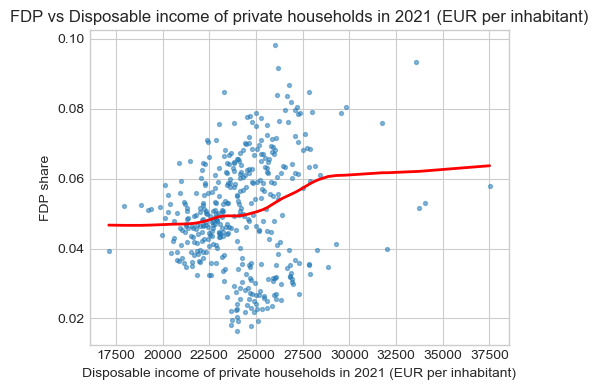

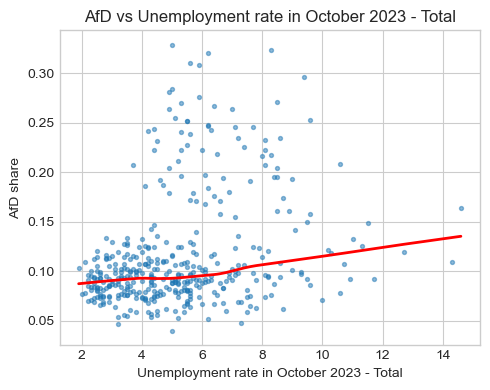

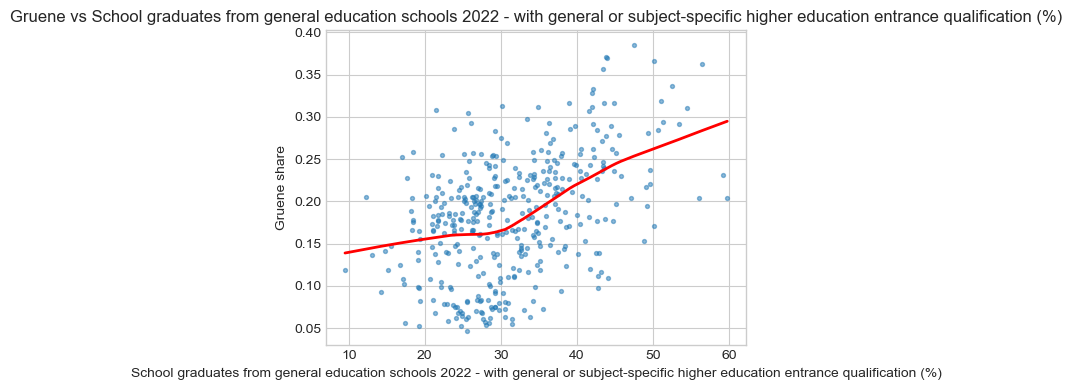

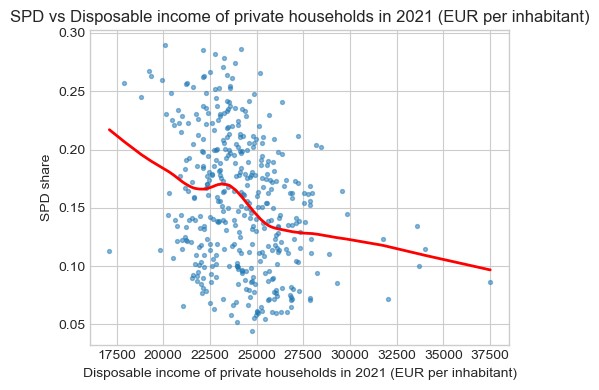

In [72]:
def scatter_lowess(df, x, y):
    mask = np.isfinite(df[x]) & np.isfinite(df[y])
    z = sm.nonparametric.lowess(df.loc[mask, y], df.loc[mask, x], frac=0.6, return_sorted=True)
    plt.figure(figsize=(5,4))
    plt.scatter(df.loc[mask, x], df.loc[mask, y], s=8, alpha=0.5)
    plt.plot(z[:,0], z[:,1], color='red', linewidth=2)
    plt.xlabel(x); plt.ylabel(f'{y} share')
    plt.title(f'{y} vs {x}')
    plt.tight_layout(); plt.show()

for x, y in [
    ('Disposable income of private households in 2021 (EUR per inhabitant)', 'FDP'),
    ('Unemployment rate in October 2023 - Total', 'AfD'),
    ('School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)', 'Gruene'),
    ('Disposable income of private households in 2021 (EUR per inhabitant)', 'SPD')
]:
    scatter_lowess(dfX, x, y)


In [58]:
m_fd = smf.ols(
    'FDP ~ Q("Disposable income of private households in 2021 (EUR per inhabitant)") + Q("Unemployment rate in October 2023 - Total") + Q("School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)") + Q("Population density on 31.12.2022 (inhabitants per km2)")',
    data=dfX
).fit()

m_af = smf.ols(
    'AfD ~ Q("Unemployment rate in October 2023 - Total") + Q("Disposable income of private households in 2021 (EUR per inhabitant)") + Q("School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)") + Q("Population density on 31.12.2022 (inhabitants per km2)")',
    data=dfX
).fit()

m_gr = smf.ols(
    'Gruene ~ Q("School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)") + Q("Disposable income of private households in 2021 (EUR per inhabitant)") + Q("Unemployment rate in October 2023 - Total") + Q("Population density on 31.12.2022 (inhabitants per km2)")',
    data=dfX
).fit()

m_sp = smf.ols(
    'SPD ~ Q("Disposable income of private households in 2021 (EUR per inhabitant)") + Q("Unemployment rate in October 2023 - Total") + Q("School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)") + Q("Population density on 31.12.2022 (inhabitants per km2)")',
    data=dfX
).fit()

print(m_fd.summary())
print(m_af.summary())
print(m_gr.summary())
print(m_sp.summary())


                            OLS Regression Results                            
Dep. Variable:                    FDP   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     28.68
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           6.33e-21
Time:                        15:37:03   Log-Likelihood:                 1140.2
No. Observations:                 398   AIC:                            -2270.
Df Residuals:                     393   BIC:                            -2251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
-----

In [59]:
dfW = dfX.merge(leaders[['District','winner_party']], on='District', how='left')

def one_vs_rest_logit(party):
    y = (dfW['winner_party'] == party).astype(int)
    X = dfW[[
        'Disposable income of private households in 2021 (EUR per inhabitant)',
        'Unemployment rate in October 2023 - Total',
        'School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)',
        'Population density on 31.12.2022 (inhabitants per km2)'
    ]]
    X = sm.add_constant(X)
    model = sm.Logit(y, X, missing='drop').fit(disp=False)
    print(f'\n=== Winner is {party} (1) vs others (0) ===')
    print(model.summary())

for p in ['FDP','SPD','AfD','Gruene']:
    if p in dfW['winner_party'].unique():
        one_vs_rest_logit(p)



=== Winner is SPD (1) vs others (0) ===
                           Logit Regression Results                           
Dep. Variable:           winner_party   No. Observations:                  398
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            4
Date:                Thu, 30 Oct 2025   Pseudo R-squ.:                  0.2400
Time:                        15:37:29   Log-Likelihood:                -55.722
converged:                       True   LL-Null:                       -73.316
Covariance Type:            nonrobust   LLR p-value:                 4.249e-07
                                                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
## 🧾 Conclusion

The analysis provides strong empirical evidence that **structural socio-economic differences are closely tied to electoral outcomes** across Germany.

- The **SPD** tends to perform better in **lower-income districts** with **higher unemployment rates**, reflecting its traditional working-class voter base.  
- The **AfD** shows stronger results in **rural, low-income, and sparsely populated** areas, indicating a link between economic marginalization and populist support.  
- The **Greens** achieve their best performance in **highly educated and urbanized** districts, confirming their appeal among voters with higher education and progressive values.  
- The **FDP** correlates positively with **income and education**, characteristic of a more affluent, professional electorate.

These patterns demonstrate that **income, education, and population density** together explain a substantial share of which party gains the **relative majority** in a given district.  
In other words, **“specific structures prevail”** — regional socio-economic characteristics significantly influence political preferences and voting behavior in the 2024 European Elections.
